In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import encode, ofdm, channels, audio, decode

cwd = os.getcwd()

In [6]:
DFT_LENGTH = 8192
CP_LENGTH = 1024
silence_duration = 1
chirp_duration = 1
fs = 48000

low_freq = 20
high_freq = 10000
double_chirp = False

encode_method = 'bpsk'
if encode_method == 'bpsk':
    bits_per_symbol = 1
elif encode_method == 'qpsk':
    bits_per_symbol = 2

In [7]:
# Generate a bit array
new = True
if new:
    np.random.seed(0)
    encoded = np.random.randint(2, size=10 * fs)
    np.savetxt('encoded', encoded, fmt='%i')

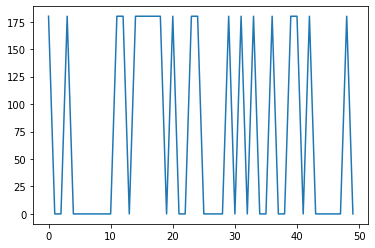

In [8]:
# Load a saved bit array
encoded = np.loadtxt('encoded', dtype=np.int32)
if encode_method == 'qpsk':
    symbols = encode.qpsk_encode(encoded)
elif encode_method == 'bpsk':
    symbols = encode.bpsk_encode(encoded)

import matplotlib.pyplot as plt
plt.plot(np.angle(symbols[:50], deg=True))
plt.show()

shifted = ofdm.subcarrier_shift_gaussian(symbols, DFT_LENGTH, fs, low_freq, high_freq, 0.01, bits_per_symbol, constellation=encode_method)


In [9]:
ofdm_data = ofdm.symbols_to_ofdm(shifted, DFT_LENGTH, CP_LENGTH)
print(ofdm_data.size)
print(ofdm_data[:10])
audio.signal_to_wav(np.real(ofdm_data), fs, 'ofdm_tester', 'audio_files')


2598912
[ 0.01462667+0.j  0.01127362+0.j -0.00119377+0.j -0.0125284 +0.j
 -0.00877044+0.j  0.00671618+0.j  0.01787919+0.j  0.0158286 +0.j
  0.00596063+0.j  0.00234768+0.j]


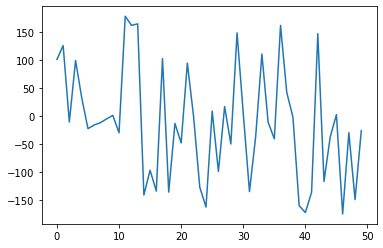

480000 480246
source:
 [0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0]
decoded:
 [0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0]


In [10]:
# Send through Octagon
octagon = channels.octagon(os.path.join(cwd, "audio_files"), fs)
impulse_channel = np.array([1])
channel = octagon

received = channels.channel_output(channel, np.real(ofdm_data))
fft = ofdm.ofdm_to_fourier(received[:ofdm_data.size], DFT_LENGTH, CP_LENGTH)
discarded = ofdm.subcarrier_extract(fft, DFT_LENGTH, fs, low_freq, high_freq)
deconvolved = ofdm.deconvolve(discarded, channel, DFT_LENGTH, fs, low_freq, high_freq)
if encode_method == 'qpsk':
    decoded = decode.qpsk_decode(deconvolved)
elif encode_method == 'bpsk':
    decoded = decode.bpsk_decode(deconvolved)
print(encoded.size, decoded.size)
print("source:\n", encoded[:30])
print("decoded:\n", decoded[:30])



In [11]:
equality = encoded == decoded[:encoded.size]
equality = equality[:]
print("correct rate:\n", np.sum(equality.astype(int))/equality.size)

correct rate:
 0.8545
